In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython import display
import geopandas as gpd
from pathlib import Path
import imageio
from itertools import chain, repeat
import warnings
warnings.filterwarnings("ignore")

## Figure 1: Geographic Distribution of Malaria

### Data Manipulation

In [2]:
malaria_deaths = pd.read_csv('Data/malaria_deaths.csv')
malaria_deaths.rename(columns = {'Deaths - Malaria - Sex: Both - Age: Age-standardized (Rate) (per 100,000 people)':
                                 'Deaths per 100,000'}, inplace = True)
malaria_deaths['bin'] = pd.cut(malaria_deaths['Deaths per 100,000'], [0, 25, 50, 100, 150, 200, 250, 300],
                               labels = ['0-25', '25-50', '50-100', '100-150', '150-200', '200-250', '>250'])

# geographic data
gdf = gpd.read_file('Data/ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp')[['ADM0_A3', 'geometry']].to_crs('+proj=robin')
gdf = gdf[gdf['ADM0_A3'] != 'ATA'] ## Antarctica is not necessary for our analysis

In [3]:
def merged_data(year):
    df = malaria_deaths[malaria_deaths['Year'] == year][['Entity', 'Code', 'bin']]
    return gdf.merge(df, left_on = 'ADM0_A3', right_on = 'Code', how = 'left')

### Figure

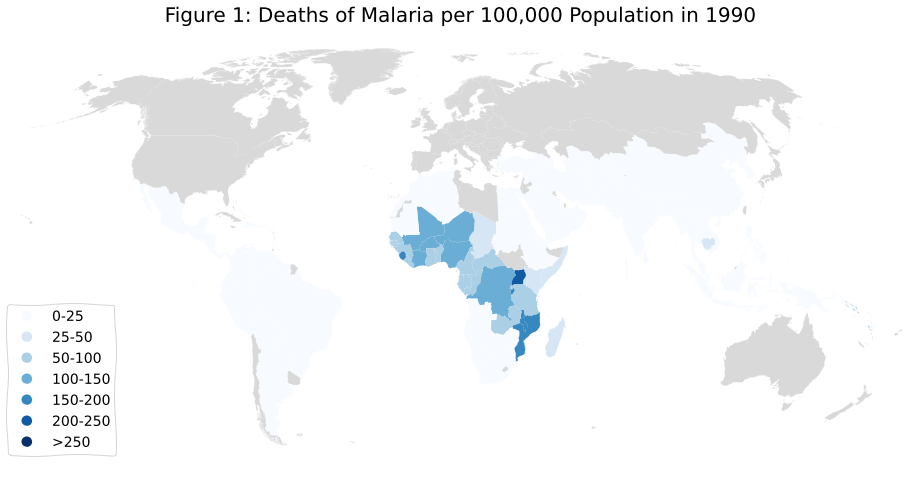

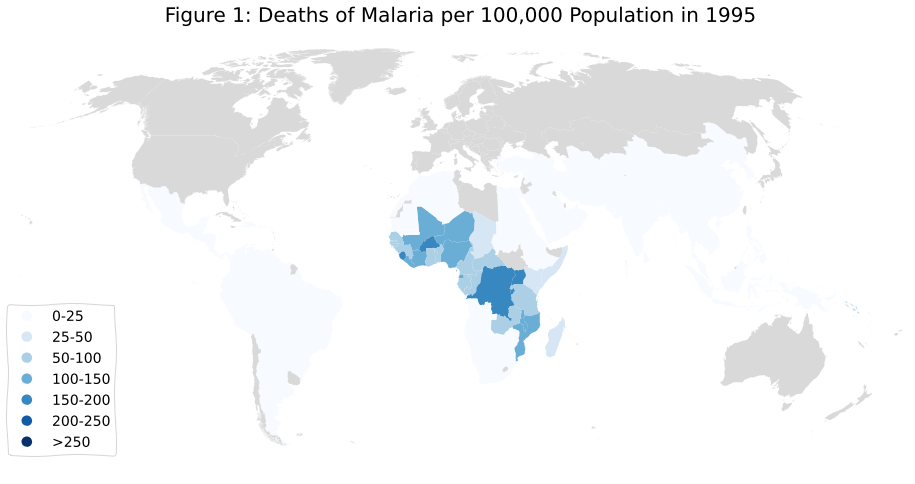

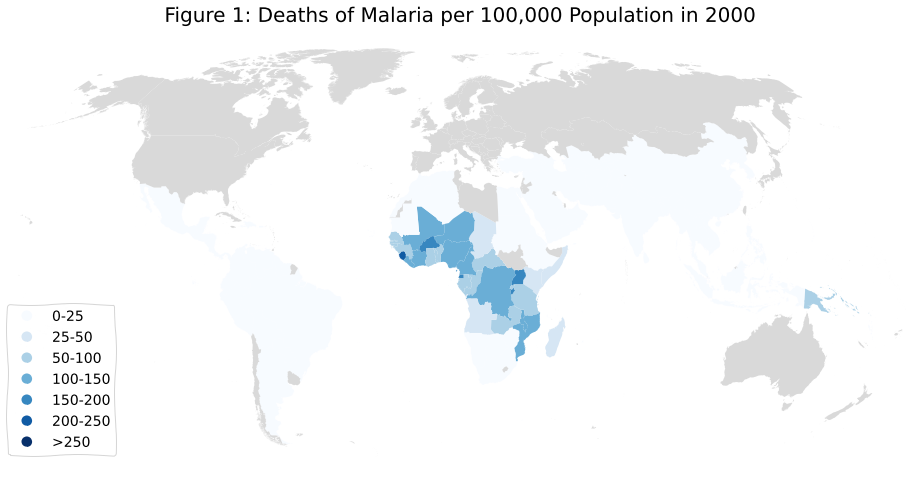

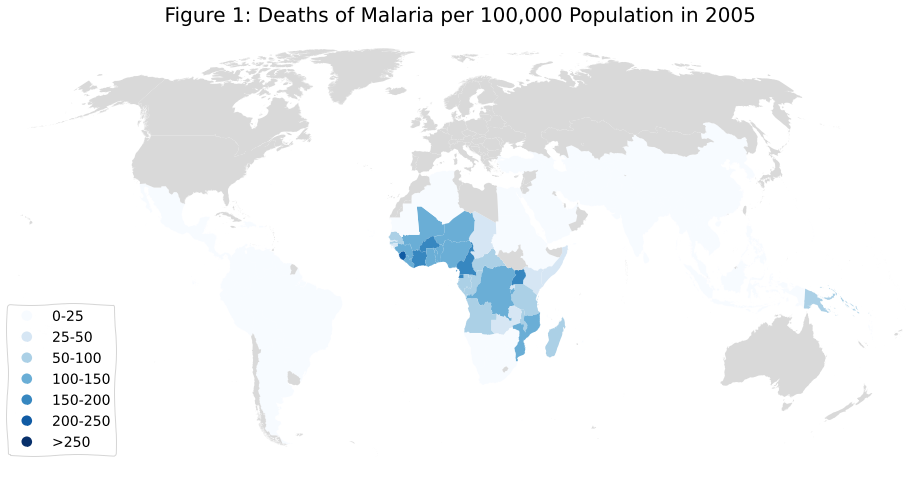

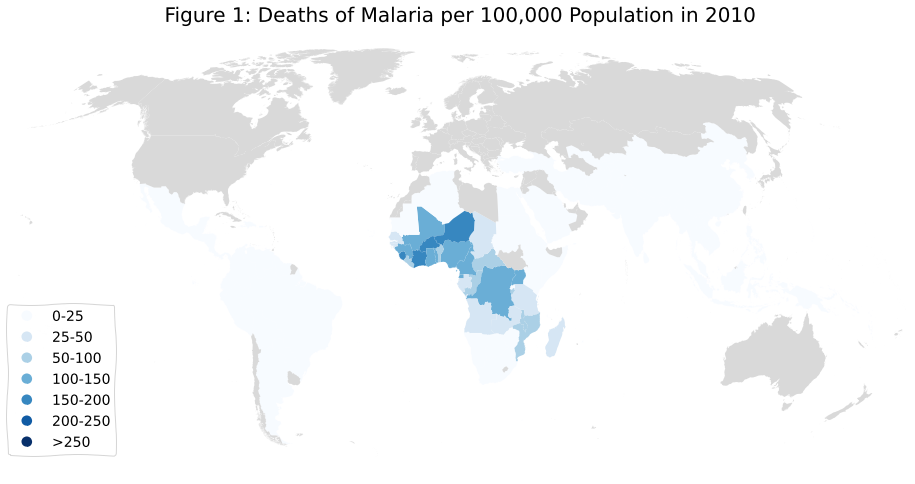

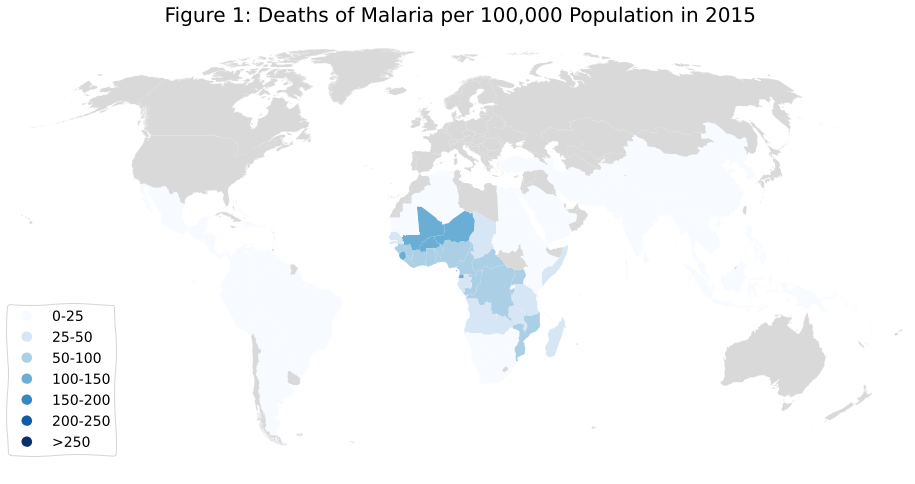

In [5]:
with plt.xkcd():
    for i in range(1990,2016,5):
        merged = merged_data(i)
        ax = merged.dropna().plot(column = 'bin', cmap = 'Blues', figsize = (16, 10), legend = True)
        merged[merged.isna().any(axis = 1)].plot(ax = ax, color = '#d9d9d9')
        ax.set_title('Figure 1: Deaths of Malaria per 100,000 Population in {}'.format(i), fontdict={'fontsize': 20}, loc='center')
        ax.set_axis_off()
        ax.set_xlim([-1.5e7, 1.7e7])
        ax.get_legend().set_bbox_to_anchor((.12, .4))
        ax.figure.savefig('./Figure/map_figure_{}.png'.format(i))

In [6]:
# animation
image_path = Path('./Figure')
images = sorted(list(image_path.glob('*.png')))
image_list = []
for file_name in images:
    image_list.append(imageio.imread(file_name))
imageio.mimwrite('./Gif/map_animation.gif', list(chain.from_iterable(zip(*repeat(image_list, 10)))))

## Figure 2: Malaria Deaths over Year for Different Age Group

### Data Manipulation

In [7]:
malaria_deaths_age = pd.read_csv('Data/malaria_deaths_age.csv', usecols = ['entity', 'code', 'year', 'age_group', 'deaths'])
deaths_sum = malaria_deaths_age.groupby(['year', 'age_group'])['deaths'].agg(np.sum)
years = np.unique(malaria_deaths_age['year'])
ages = np.unique(malaria_deaths_age['age_group'])

### Figure

In [8]:
deaths_sum_round = round(deaths_sum, 2)
labels = ["""year {}
age {}: {}
age {}: {}
age {}: {}
age {}: {}
age {}: {}""".format(years[i],
                     ages[4], deaths_sum_round[(5*i):(5*i+5)].to_list()[4],
                     ages[1], deaths_sum_round[(5*i):(5*i+5)].to_list()[1],
                     ages[0], deaths_sum_round[(5*i):(5*i+5)].to_list()[0],
                     ages[2], deaths_sum_round[(5*i):(5*i+5)].to_list()[2],
                     ages[3], deaths_sum_round[(5*i):(5*i+5)].to_list()[3]) for i in range(len(years))]

In [9]:
with plt.xkcd():
    fig = plt.figure(figsize = (12,6))
    ax = fig.add_axes([0.1, 0.1, 0.6, 0.75])
    for j in range(len(ages)):
        plt.plot(years, deaths_sum[j:][::5], label = 'age:' + ages[j])
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, prop={'size': 15})
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.title('Figure 2: Total Number of Deaths for Different Age Group', fontdict = {'fontsize': 18}, pad = 20)

lines = plt.axvline(x = years[0], linestyle = '--', color = 'black')
annotation = plt.annotate(labels[0], xy=(years[0]+2, 1e+6), xytext=(-20, 20),
                          textcoords='offset points', ha='left', va='bottom',
                          bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.5))

def animate(i):
    global lines
    global annotation
    
    lines.remove()
    annotation.remove()
    lines = plt.axvline(x = years[i], linestyle = '--', color = 'black')
    if i <= 15:
        annotation = plt.annotate(labels[i], xy=(years[i]+2, 1e+6), xytext=(-20, 20),
                                  textcoords='offset points', ha='left', va='bottom',
                                  bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.5))
    else:
        annotation = plt.annotate(labels[i], xy=(years[i], 1e+6), xytext=(-200, 20),
                                  textcoords='offset points', ha='left', va='bottom',
                                  bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.5))
    annotation.set_fontsize(13)

anni = FuncAnimation(fig, animate, frames = len(years), interval = 1000)
video = anni.to_html5_video()
html = display.HTML(video)
display.clear_output(wait = True)
display.display(html)
plt.close()

## Figure 3: Malaria Incidents vs Financial Condition

### Data Manipulation

In [10]:
malaria_inc = pd.read_csv('Data/malaria_inc.csv')
malaria_inc.rename(columns = {'Incidence of malaria (per 1,000 population at risk) (per 1,000 population at risk)':
                              'Incidence per 1,000'}, inplace = True)

# data of population and GPD per capita
data_pop_gdp = pd.read_csv('Data/data_pop_gdp.csv', encoding='Windows-1252')
data_pop_gdp = data_pop_gdp.replace(['Gross domestic product based on purchasing-power-parity (PPP) per capita GDP'],
                                    'GDP')

# add region of country
region = pd.read_csv('Data/region.csv', encoding='Windows-1252')

In [11]:
def data_year(year):
    # merge datasets
    df_pop_gdp = pd.DataFrame({'Country': np.array(data_pop_gdp['Country'][::2]),
                               'GDP': np.array(data_pop_gdp[str(year)][::2]),
                               'Population': np.array(data_pop_gdp[str(year)][1:][::2])})
    df_target = df_pop_gdp.merge(malaria_inc[malaria_inc['Year'] == year][['Entity','Incidence per 1,000']], 
                                 left_on = 'Country', right_on = 'Entity')
    df_target['GDP'] = df_target['GDP'].str.replace(',', '').astype(float)
    df_target['Population'] = df_target['Population'].str.replace(',', '').astype(float)
    df_target = df_target.merge(region, on = 'Country')
    group_codes = {k: idx for idx, k in enumerate(df_target['Region'].unique())}
    df_target['Region'] = df_target['Region'].apply(lambda x: group_codes[x])
    
    top = pd.concat([df_target.sort_values('Population', ascending = False)[:4],
                     df_target.sort_values('Incidence per 1,000', ascending = False)[:1],
                     df_target.sort_values('GDP', ascending = False)[:3]]).drop_duplicates()
    
    return df_target, group_codes, top

### Figure

In [12]:
with plt.xkcd():
    fig = plt.figure(figsize = (10, 6))
    ax = fig.add_axes([0.1, 0.15, 0.55, 0.75])
    plt.xlabel('GDP per capita (log)',fontsize = 15)
    plt.ylabel('Incidence per 1,000 (log)',fontsize = 15)
    plt.xticks(np.arange(6, 12), fontsize = 15)
    plt.yticks(np.arange(-9, 8, 3), fontsize = 15)
    plt.xlim([5.5, 11])
    plt.ylim([-9, 8.2])

scatter = plt.scatter(np.log(data_year(2000)[0]['GDP']), np.log(data_year(2000)[0]['Incidence per 1,000']),
                      s = data_year(2000)[0]['Population'], c = data_year(2000)[0]['Region'], cmap = 'YlGnBu')
legend = plt.legend(handles = scatter.legend_elements(num = [0,1,2,3,4,5])[0], labels = data_year(2000)[1].keys(),
                    bbox_to_anchor = (1.05, 1), loc=2, prop = {'size': 15})
plt.title('Figure 3: Malaria Incidents vs GDP per Capita in 2000', fontdict = {'fontsize': 18}, pad = 20)
text = [plt.text(np.log(data_year(2000)[2].iloc[i,:]['GDP']), np.log(data_year(2000)[2].iloc[i,:]['Incidence per 1,000']),
                 data_year(2000)[2].iloc[i,:]['Country'], fontsize = 15, horizontalalignment = 'right') for i in range(8)]

def animate(i):
    global scatter
    global legend
    
    scatter.remove()
    scatter = plt.scatter(np.log(data_year(i*5+2000)[0]['GDP']), np.log(data_year(i*5+2000)[0]['Incidence per 1,000']), 
                          s = data_year(i*5+2000)[0]['Population'], c = data_year(i*5+2000)[0]['Region'], cmap = 'YlGnBu')
    legend.remove()
    legend = plt.legend(handles = scatter.legend_elements(num = [0,1,2,3,4,5])[0], labels = data_year(i*5+2000)[1].keys(),
                        bbox_to_anchor = (1.05, 1), loc=2, prop = {'size': 15})
    [text[j].set_x(np.log(data_year(i*5+2000)[2].iloc[j,:]['GDP'])) for j in range(8)]
    [text[j].set_y(np.log(data_year(i*5+2000)[2].iloc[j,:]['Incidence per 1,000'])) for j in range(8)]
    [text[j].set_text(data_year(i*5+2000)[2].iloc[j,:]['Country']) for j in range(8)]
    plt.title('Figure 3: Malaria Incidents vs GDP per Capita in {}'.format(i*5+2000), fontdict = {'fontsize': 18}, pad = 20)

anni = FuncAnimation(fig, animate, frames = 4, interval = 1000)
video = anni.to_html5_video()
html = display.HTML(video)
display.clear_output(wait = True)
display.display(html)
plt.close()